In [1]:
import os
import yaml
from pathlib import Path


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import cartopy.crs as ccrs



from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


from torch import utils
# import pytorch_lightning as pl
import lightning.pytorch as pl

import model.StNN_index as stnn_index
import model.StNN_static as stnn

from utils import statics_from_config
from dataset.datasets_wrapped import TransferData, WeatherDataset
from utils_data import generate_clim_pred, load_data
from plot_utils import *
import utils_evaluation as eval




In [2]:
import matplotlib as mpl
mpl.get_configdir()

'/mnt/beegfs/home/bommer1/.config/matplotlib'

In [3]:
plt.style.use('seaborn')


/tmp/ipykernel_67746/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Model and Prediction Function

# Results

In [4]:
# Set hyperparameters.
arch_type = 'Index_LSTM' # 'LSTM' # 'ViT'
cm_list = ['#7fbf7b','#1b7837','#762a83','#9970ab','#c2a5cf']  #762a83
regimes = ['SB', 'NAO-', 'AR', 'NAO+']
if arch_type == 'ViT':

        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch}'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)


        base_dir = config['base_dir']
        lr_dir = config['lr_dir']

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
        
elif arch_type == 'LSTM':
        cfile = '_1980_olr'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)


        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
        result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)

        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'
else:
        cfile = '_1980_index'
        config = yaml.load(open(f'./config/convlstm_config{cfile}.yaml'), Loader=yaml.FullLoader)

        config_base = yaml.load(open(f'./config/convlstm_config_1980_olr.yaml'), Loader=yaml.FullLoader)

        strt_yr = config.get('strt','')
        trial_num = config.get('version', '')
        norm_opt = config.get('norm_opt','')
        arch = config.get('arch', 'ViT')
        tropics = config.get('tropics', '')
        temp_scaling = config.get('temp_scaling', False)

        if '_9cat' in config['var_comb']['input'][0]:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}_9cat/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}_9cat/'
        else:
                stat_dir =  config['net_root'] + f'Statistics/{arch_type}/'
                result_path = f'/mnt/beegfs/home/bommer1/WiOSTNN/Data/Results/Statistics/{arch_type}/'
        results_directory = Path(f'{result_path}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/')
        os.makedirs(results_directory, exist_ok=True)
        mod_name = 'spatiotemporal_Neural_Network'
        architecture = stnn_index.spatiotemporal_Neural_Network

        base_name = 'exp_lstm_baseline_LSTM_decoder_sst-u-nae_regimes'
        lr_name = 'finalized_model.sav'

test_loader, data_set, cls_wt, test_set, infos = load_data(config)

var_comb = config['var_comb']

data_info, _ = statics_from_config(config)

seasons =  {'train':{config['data']['dataset_name2']:list(range(config['data']['fine']['train_start'], config['data']['fine']['train_end']))},
'val':{config['data']['dataset_name2']:list(range(config['data']['fine']['val_start'], config['data']['fine']['val_end']))},
'test':{config['data']['dataset_name2']:list(range(config['data']['fine']['test_start'], config['data']['fine']['test_end']))}}

~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc
~/WiOSTNN/Version1/data/ERA5/datasets/z_500_1.40625deg_1980-2023_northern_hemi_2d_NAEregimes.nc


In [5]:
# Load collected data.
exp_dir =  f"{stat_dir}version_{strt_yr}{trial_num}_{norm_opt}{tropics}/"
pths = [xs for xs in Path(exp_dir).iterdir() if xs.is_dir()]

if temp_scaling:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}_temp_scale.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model_temp_scale.npz')
else:
    data_collect = np.load(f'{results_directory}/collected_loop_data_{len(pths)-1}.npz')
    data_result = np.load(f'{results_directory}/accuracy_{len(pths)-1}model.npz')
    
persistance = data_collect['persistance'] 
sst = data_collect['sst'] 
u10 = data_collect['u10'] 
dates = data_collect['dates'] 
daytimes = data_collect['daytimes']
loop_probabilities = data_collect['loop_probabilities']
loop_classes = data_collect['loop_classes']
predictions_baseline = data_collect['predictions_baseline']
targets = data_collect['targets']

In [6]:
input_reg = []
for input, output, weeks, days in data_set:
    if arch_type == 'Index_LSTM':
        input_reg.append(input[1][None,:,-4:].numpy().squeeze())
    else:
        input_reg.append(np.array(input[1]).squeeze())


input_reg = np.concatenate(input_reg).reshape((predictions_baseline.shape[0],
                                                           predictions_baseline.shape[1],4))

In [7]:
# load climatology
smoothing = 7
num_m = 14
dtset_name = config['data']['dataset_name2']

clim_prob = xr.load_dataarray(f'/mnt/beegfs/home/bommer1/WiOSTNN/Version1/data/{dtset_name}/climatology/NAE_{num_m}eofs_prob_{smoothing}days_climatology_1980_2009.nc')
predictions_clim = generate_clim_pred(clim_prob, dates)
predictions_clim_classes = np.argmax(predictions_clim, 2)

### All confidences

In [8]:
true_labels = targets.flatten()
lp_pr = loop_probabilities.reshape(loop_classes.shape[0],loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])

confidences = np.zeros((loop_classes.shape[0],loop_classes.shape[1],loop_classes.shape[2]))
num_preds = loop_classes.shape[0]*loop_classes.shape[1]
for k in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for i in range(loop_probabilities.shape[2]):
            confidences[k,j,i] = loop_probabilities[k, j, i, targets[j,i]]

In [9]:
loop_targets = np.repeat(targets[None,:,:], loop_classes.shape[0], axis = 0)
confidences_flat = confidences.flatten()
lp_conf = loop_probabilities.flatten()
q_all, q_90 = 85, 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
targ_all_90 = []
acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    if l == loop_targets[i,j,k]:
                        acc_count +=1
                    all_count +=1
                    conf_all_90.append(loop_probabilities[i,j,k,l])

                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])
print(acc_count/all_count)
conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)

0.2608580997336568


## Skill analysis

### Averaged Brier skill score

In [10]:
# Build loop baselines

loop_clim = np.repeat(predictions_clim, loop_classes.shape[0],axis=0)
loop_u10 = np.repeat(u10[None,...], loop_classes.shape[0],axis=0)
loop_sst = np.repeat(sst[None,...], loop_classes.shape[0],axis=0)
loop_tgs = loop_targets.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_cls = loop_classes.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2])
loop_prbs = loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1],loop_classes.shape[2],loop_probabilities.shape[3])

loop_hps= loop_probabilities.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_clims = loop_clim.reshape(loop_classes.shape[0]*loop_classes.shape[1]*loop_classes.shape[2],loop_probabilities.shape[3])[confidences_flat>q_90,:]
loop_tgss = loop_targets.flatten()[confidences_flat>q_90]


## Index Comparison

In [11]:
index_path = '/mnt/beegfs/home/bommer1/WiOSTNN/Data/Index'
mjo_index = np.load(f'{index_path}/MJO_index_1980-2023_mjo_testset.npz')
pv_index = np.load(f'{index_path}/pv_index_1980-2023_spv_testset.npz')

mjo_index_in = mjo_index['input']
mjo_index_out = mjo_index['output']
daytimes = mjo_index['daytimes']
dates = mjo_index['dates']

pv_index_in = pv_index['input']
pv_index_out = pv_index['output']

In [12]:
pv_inputs = np.repeat(pv_index_in[None,:,:], loop_classes.shape[0], axis = 0)
pv_outputs = np.repeat(pv_index_out[None,:,:], loop_classes.shape[0], axis = 0)
mjo_inputs = np.repeat(mjo_index_in[None,:,:], loop_classes.shape[0], axis = 0)
mjo_outputs = np.repeat(mjo_index_out[None,:,:], loop_classes.shape[0], axis = 0)
nae_inputs = np.repeat(np.argmax(input_reg, axis = -1)[None,:,:], loop_classes.shape[0], axis = 0)


In [13]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)
conf_all_90 = []
pred_all_90 = []
ts_all_90 = []
targ_all_90 = []
pv_all_90 = []
mjo_all_90 = []

acc_count =0
all_count =0
for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for l in range(loop_probabilities.shape[3]):
                if loop_probabilities[i,j,k,l] > qall_90: 
                    conf_all_90.append(loop_probabilities[i,j,k,l])
                    pv_all_90.append(pv_inputs[i,j,:])
                    mjo_all_90.append(mjo_inputs[i,j,:])
                    ts_all_90.append(f'lead week {k+1}')
                    pred_all_90.append(l)
                    targ_all_90.append(loop_targets[i,j,k])

conf_all_90 = np.array(conf_all_90)
pred_all_90 = np.array(pred_all_90)
targ_all_90 = np.array(targ_all_90)
pv_all_90 = np.array(pv_all_90)
mjo_all_90 = np.array(mjo_all_90)


In [14]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)

input_reg_prob = input_reg
input_reg = np.argmax(input_reg, axis = 2)
# regimes = ['SB', 'NAO-', 'NAO+', 'AR']

occ_mjo = np.zeros((4,8))
cnts_reg_in = np.zeros((4,))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):

            if not np.isnan(mjo_inputs[i,j,k]):
                cnts_reg_in[loop_targets[i,j,k]] += 1
                occ_mjo[loop_targets[i,j,k], int(mjo_inputs[i,j,k])-1] += 1


unq_reg, cnts_reg = np.unique(targ_all_90, return_counts=True)
# unq_reg_in, cnts_reg_in = np.unique(input_reg, return_counts=True)
unq_reg_pred, cnts_reg_pred = np.unique(loop_classes, return_counts=True)
unq_mjo, cnts_mjo = np.unique(mjo_all_90, return_counts=True)
cnts_mjo = cnts_mjo[:8]
pred_reg = cnts_reg_pred/cnts_reg_pred.sum()
clim_occ_mjo = occ_mjo/np.repeat(cnts_reg_in[:,None],8,axis=1)

In [15]:
np.savez(f'{results_directory}{arch_type}mjo_spv_teleconnections.npz', conf_all_90 = conf_all_90, pred_all_90 = pred_all_90,
         targ_all_90 = targ_all_90, pv_all_90 = pv_all_90, mjo_all_90 = mjo_all_90)


In [16]:
sum_spv_reg = np.zeros((4,1))
cnts_reg_in  = np.zeros((4,1))


for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                if not np.isnan(pv_inputs[i,j,t]):
                    cnts_reg_in[input_reg[j,k]] += 1
                    sum_spv_reg[input_reg[j,k]] += pv_inputs[i,j,t]

avg_spv = (sum_spv_reg.T/cnts_reg_in).flatten()


pv_anomalies = np.zeros(pv_inputs.shape)

for i in range(loop_probabilities.shape[0]):
    for j in range(loop_probabilities.shape[1]):
        for k in range(loop_probabilities.shape[2]):
            for t in range(pv_inputs.shape[2]):
                    if not np.isnan(pv_inputs[i,j,t]):
                        # d_t = np.abs((t-5)) + (k+1)
                        pv_anomalies[i,j,t] = pv_inputs[i,j,t]- avg_spv[input_reg[j,k]]

In [25]:
# conditional probabilities.
frac = 0.8
t_in, t_out = pv_inputs.shape[2],loop_probabilities.shape[2]
sampled_nae_ls = []
for mod in range(loop_probabilities.shape[0]): 
    sub_indx = np.random.choice(np.arange(loop_probabilities.shape[0]), 
                                size = int(frac*loop_probabilities.shape[0]), replace = False)
    sub_nae = nae_inputs[sub_indx,...]
    sub_lp = loop_probabilities[sub_indx,...]
    sub_targets = loop_targets[sub_indx,...]

    nae_conditional_count = np.zeros((len(regimes),len(regimes),t_in +t_out-1))
    nae_unconditional_count = np.zeros((len(regimes),t_in +t_out-1))
    for i in range(sub_lp.shape[0]):
        for j in range(sub_lp.shape[1]):
            for k in range(sub_lp.shape[2]):
                for t in range(nae_inputs.shape[2]):
                    if not np.isnan(sub_nae[i,j,k]):
                        if not qall_90:
                            d_t = np.abs((t-5)) + (k+1)
                            nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]), d_t-1] += 1
                            nae_unconditional_count[sub_targets[i,j,k], d_t-1] += 1
                        else:
                            if sub_lp[i,j,k,sub_targets[i,j,k]] > qall_90:
                                d_t = np.abs((t-5)) + (k+1)
                                nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]), d_t-1] += 1
                                nae_unconditional_count[sub_targets[i,j,k], d_t-1] += 1


    nae_conditional_total = np.sum(nae_conditional_count, axis = 0)
    nae_unconditional_total = np.sum(nae_unconditional_count, axis = 0)
    nae_conditional_pc = nae_conditional_count/np.repeat(nae_conditional_total[None,:,:],len(regimes),axis=0)
    nae_unconditional_pc = nae_unconditional_count/np.repeat(nae_unconditional_total[None,:],len(regimes),axis=0)
            
    nae_probability_change = 100 *(nae_conditional_pc - np.repeat(nae_unconditional_pc[:,None,:],len(regimes),axis=1))

    sampled_nae_ls.append(nae_probability_change[None,...])

sampled_naes = np.concatenate(sampled_nae_ls)

probability_nae_ls = []
probability_nae_array = np.zeros((len(regimes),len(regimes),t_in +t_out-1))
for r in range(len(regimes)):
    for shift_value in range(t_in +t_out-1):
        for label in range(len(regimes)):
            probability_change = sampled_naes[:,label,r,shift_value]

            mean = np.nanmean(probability_change)
            print(f'{shift_value} weeks, {regimes[r]} to {regimes[label]}: {mean}')
            pc_975 = np.nanpercentile(probability_change ,97.5)
            pc_025 = np.nanpercentile(probability_change, 2.5)

            if np.sign(pc_025)==np.sign(pc_975):
                significance = 1
            else:
                significance = 0

            probability_nae_ls.append(pd.DataFrame(data={
                "NAE regime": [r+1],
                "Lag (weeks)": [shift_value+1],
                "predicted NAE regime": [label+1],
                "mean": [mean],
                "significance": [significance]}))
            
            probability_nae_array[label,r,shift_value] = mean

probability_nae = pd.concat(probability_nae_ls)

/tmp/ipykernel_67746/4214735097.py:32: RuntimeWarning: invalid value encountered in divide
  nae_conditional_pc = nae_conditional_count/np.repeat(nae_conditional_total[None,:,:],len(regimes),axis=0)
/tmp/ipykernel_67746/4214735097.py:33: RuntimeWarning: invalid value encountered in divide
  nae_unconditional_pc = nae_unconditional_count/np.repeat(nae_unconditional_total[None,:],len(regimes),axis=0)


0 weeks, SB to SB: nan
0 weeks, SB to NAO-: nan
0 weeks, SB to AR: nan
0 weeks, SB to NAO+: nan
1 weeks, SB to SB: -6.889842877770689
1 weeks, SB to NAO-: 0.0
1 weeks, SB to AR: -1.8192171476565784
1 weeks, SB to NAO+: 8.70906002542727
2 weeks, SB to SB: -27.63347399791641
2 weeks, SB to NAO-: -0.07084341271727204
2 weeks, SB to AR: 23.147639677210876
2 weeks, SB to NAO+: 4.556677733422802
3 weeks, SB to SB: -35.43576912714625
3 weeks, SB to NAO-: -0.3241641044410786
3 weeks, SB to AR: 48.4208109352929
3 weeks, SB to NAO+: -12.660877703705577
4 weeks, SB to SB: -37.54797095568528
4 weeks, SB to NAO-: -0.5600198558724682
4 weeks, SB to AR: 34.77079140627824
4 weeks, SB to NAO+: 3.337199405279512
5 weeks, SB to SB: -15.076674189728589
5 weeks, SB to NAO-: -0.818331882480565
5 weeks, SB to AR: 4.9159833065037795
5 weeks, SB to NAO+: 10.979022765705373
6 weeks, SB to SB: 13.0668343951638
6 weeks, SB to NAO-: -0.818331882480565
6 weeks, SB to AR: -8.79812374085562
6 weeks, SB to NAO+: -3.45

/tmp/ipykernel_67746/4214735097.py:48: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(probability_change)
/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [24]:
probability_nae

,NAE regime,Lag (weeks),predicted NAE regime,mean,significance
0,1,1,1,NaN,0
0,1,1,2,NaN,0
0,1,1,3,NaN,0
0,1,1,4,NaN,0
0,1,2,1,-6.695171,1
...,...,...,...,...,...
0,4,10,4,-30.770507,1
0,4,11,1,42.152177,1
0,4,11,2,2.653088,1
0,4,11,3,2.260352,1


ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

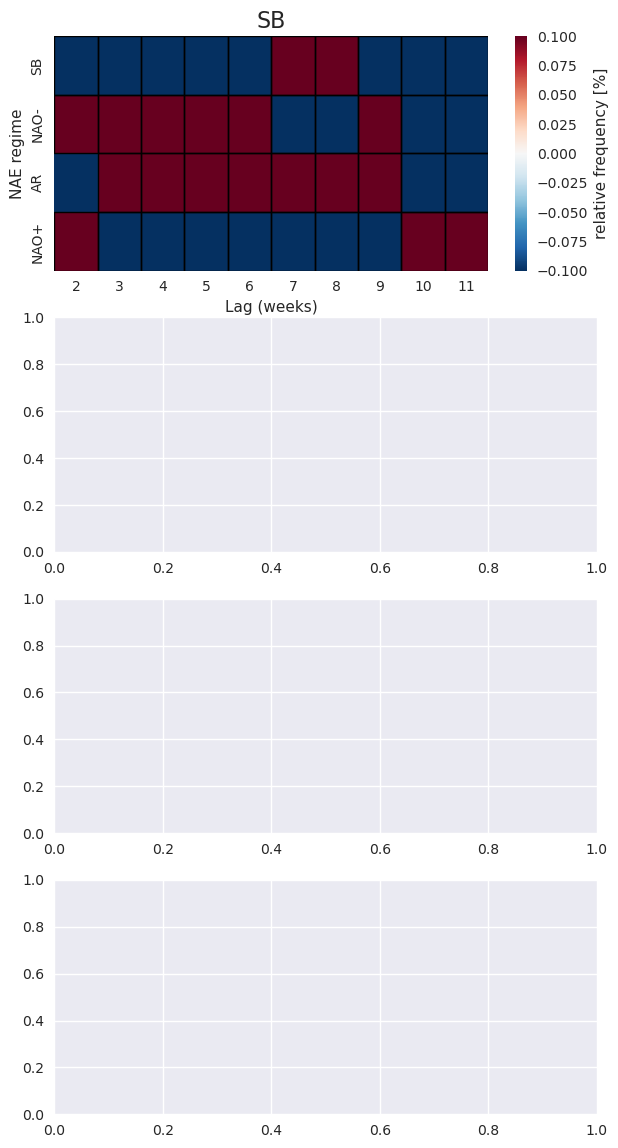

In [18]:
from matplotlib.patches import Rectangle
chosen_cluster_number = 4
vmin = np.abs(np.min(probability_nae_array))
vmax = np.max(probability_nae_array)
vmax = max([vmin,vmax]) 
delta_t = [-(t+1) for t in range(t_in +t_out-1)]

fig, axes = plt.subplots(len(regimes), 1, figsize=(7, 14))

for i in range(len(regimes)):

    cbar_flag = True if i == len(regimes)-1 else False

    plot_data = probability_nae[probability_nae["predicted NAE regime"]==i+1]
    plot_data = plot_data[plot_data["NAE regime"]!=0]
    heatmap_data = pd.pivot_table(plot_data, values='mean', index=["NAE regime"], columns='Lag (weeks)')
    
    g = sns.heatmap(heatmap_data, cmap='RdBu_r', square=False, ax = axes[i], vmin=-vmax, vmax = vmax, 
                    cbar_kws={"label": 'relative frequency [%]'})
    g.set_title(f'{regimes[i]}', fontsize=16)
    for index, row in plot_data[plot_data['significance'] == 1].iterrows():
        name_pos = heatmap_data.index.get_loc(row["NAE regime"])
        id_pos = heatmap_data.columns.get_loc(row['Lag (weeks)'])
        g.add_patch(Rectangle((id_pos, name_pos), 1, 1, ec='black', fc='none', lw=1))
    axes[i].set_yticklabels(regimes) 
    # axes[i].invert_xaxis()  
    axes[i].set_xticklabels(delta_t) 
        
plt.tight_layout()

ValueError: The number of FixedLocator locations (10), usually from a call to set_ticks, does not match the number of labels (11).

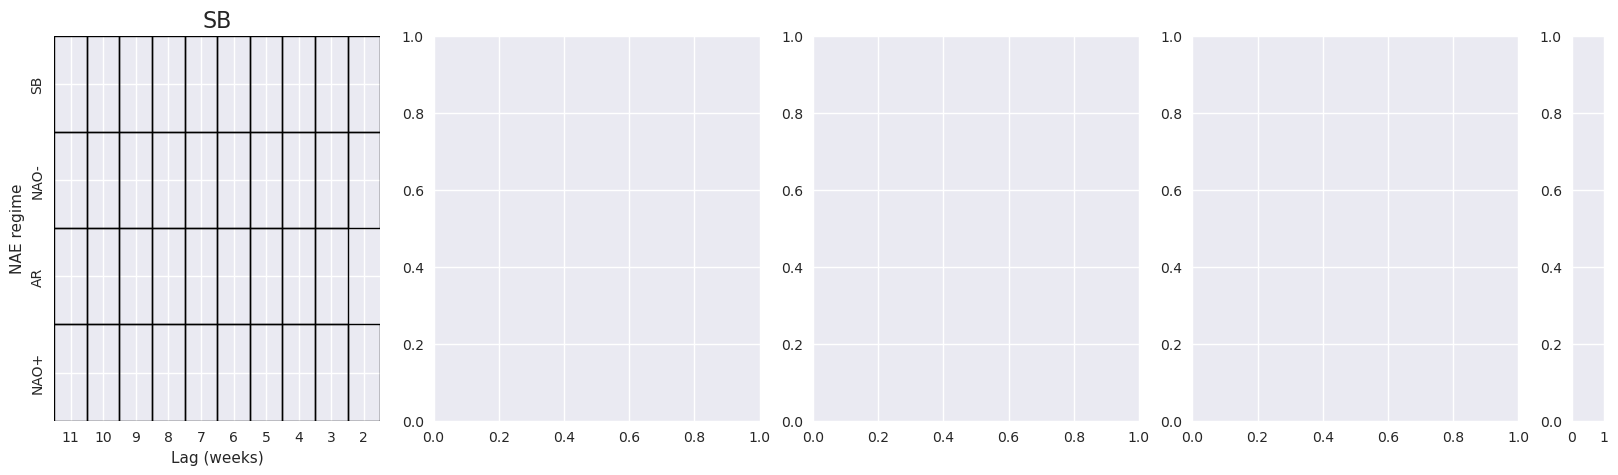

In [31]:
from matplotlib.patches import Rectangle

vmin = np.abs(np.min(probability_nae_array))
vmax = np.max(probability_nae_array)
vmax = max([vmin,vmax]) 
delta_t = [-(t+1) for t in range(t_in +t_out-1)]

fig, axes = plt.subplots(1, len(regimes)+1, figsize=(20, 5), #figsize=(7, 14))
                            gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]})
for i in range(len(regimes)):

    cbar_flag = True if i == len(regimes)-1 else False

    plot_data = probability_nae[probability_nae["predicted NAE regime"]==i+1]
    plot_data = plot_data[plot_data["NAE regime"]!=0]
    heatmap_data = pd.pivot_table(plot_data, values='mean', index=["NAE regime"], columns='Lag (weeks)')
    
    g = sns.heatmap(heatmap_data, cmap='RdBu_r', square=False, ax = axes[i], vmin=-vmax, vmax = vmax, 
                    cbar=cbar_flag, cbar_ax=axes[-1], cbar_kws={"label": 'relative frequency [%]'})
    g.set_title(f'{regimes[i]}', fontsize=16)
    for index, row in plot_data[plot_data['significance'] == 1].iterrows():
        name_pos = heatmap_data.index.get_loc(row["NAE regime"])
        id_pos = heatmap_data.columns.get_loc(row['Lag (weeks)'])
        g.add_patch(Rectangle((id_pos, name_pos), 1, 1, ec='black', fc='none', lw=1))
    if i == 0:
        axes[i].set_ylabel('NAE regime')
        axes[i].set_yticklabels(regimes) 
    else:
        axes[i].set_ylabel('')
        axes[i].set_yticklabels([]) 


    axes[i].invert_xaxis()  
    axes[i].set_xticklabels(np.flip(delta_t)) 
        
plt.tight_layout()

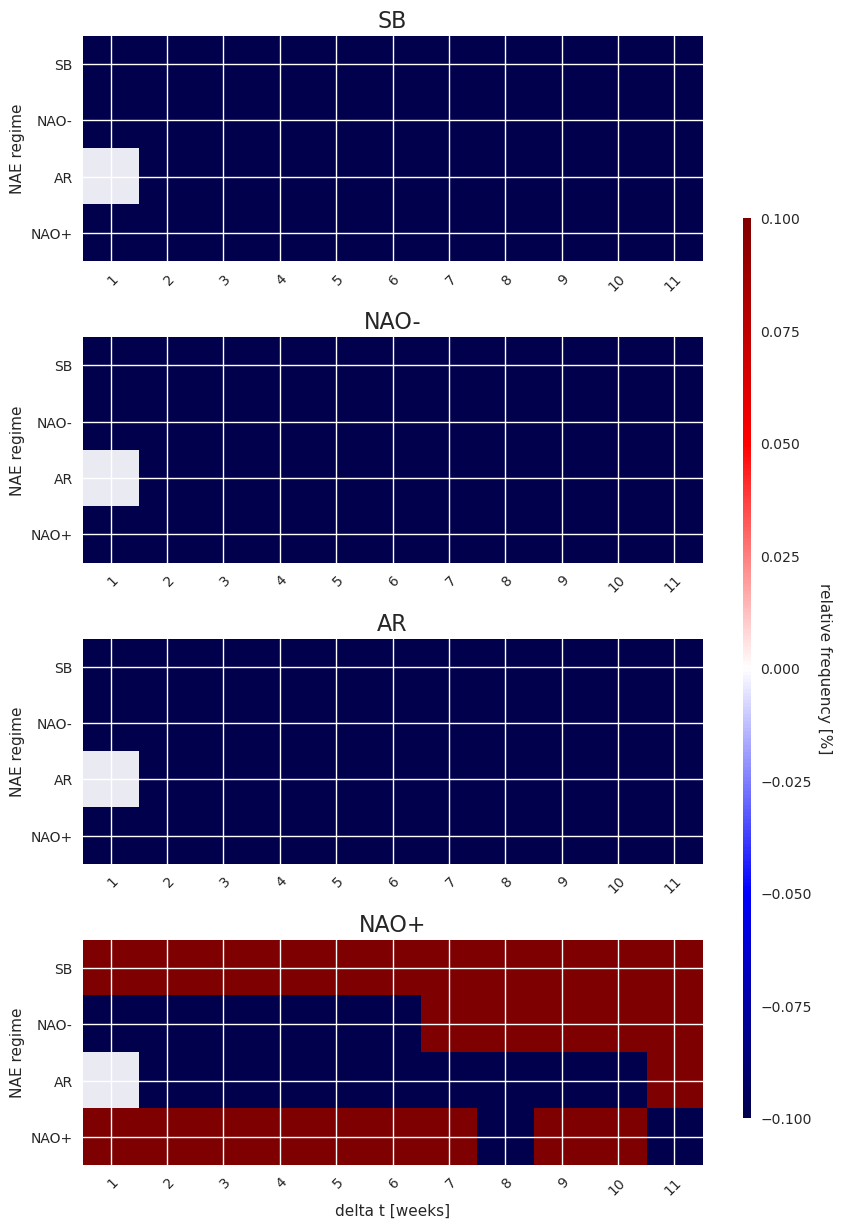

In [97]:
fig, axes = plt.subplots(len(regimes), 1, figsize=(8,15))#, sharex = True)

delta_t = np.array([dt+1 for dt in range(t_in + t_out-1)])
mjo_ind = np.arange(1,int(unq_mjo[7])+1)
vmin = np.abs(np.min(probability_nae_array))
vmax = np.max(probability_nae_array)
vmax = max([vmin,vmax]) 

# for i, (keys, plot_val_mjo) in enumerate(delta_t_mjo.items()):
for r in range(probability_nae_array.shape[0]):

    keys = regimes[r]
    cbar_flag = True if r == len(regimes)-1 else False
    ax = axes[r]

    im = ax.imshow(probability_nae_array[r, :, :], cmap = 'seismic', vmin=-vmax, vmax=vmax, interpolation='nearest')#, cbar=cbar_flag, cbar_ax=axes[-1],)
    if r == len(regimes)-1:
        ax.set_xlabel(f'delta t [weeks]')
    ax.set_ylabel(f'NAE regime')

    ax.set_xticks(range(len(delta_t)), labels=delta_t,
              rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(len(regimes)))
    

    ax.set_title(f'{keys}', fontsize=16)
    ax.set_yticklabels(regimes)   
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.6])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_ylabel('relative frequency [%]', rotation=-90, va="bottom")

fig.savefig(f"{results_directory}/deltaT_90th_probability_mjoPhase.png", dpi=600, bbox_inches='tight')

## Timestep-wise 

In [32]:
import utils_woo as woo

# conditional probabilities.
frac = 0.8
t_in, t_out = nae_inputs.shape[2],loop_probabilities.shape[2]
sampled_nae_ls = []
for mod in range(loop_probabilities.shape[0]): 
    sub_indx = np.random.choice(np.arange(loop_probabilities.shape[0]), 
                                size = int(frac*loop_probabilities.shape[0]), replace = False)
    sub_nae = nae_inputs[sub_indx,...]
    sub_lp = loop_probabilities[sub_indx,...]
    sub_targets = loop_targets[sub_indx,...]

    nae_conditional_count = np.zeros((len(regimes),len(regimes),sub_lp.shape[2], t_in +t_out-1))
    nae_unconditional_count = np.zeros((len(regimes),sub_lp.shape[2], t_in +t_out-1))
    nae_conditional_count[:] = np.nan
    nae_unconditional_count[:] = np.nan
    for i in range(sub_lp.shape[0]):
        for j in range(sub_lp.shape[1]):
            for k in range(sub_lp.shape[2]):
                for t in range(nae_inputs.shape[2]):
                    d_t = np.abs((t-5)) + (k+1)

                    if np.isnan(nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]),k, d_t-1]):
                        nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]),k, d_t-1] = 0
                    if np.isnan(nae_unconditional_count[sub_targets[i,j,k],k, d_t-1]):
                        nae_unconditional_count[sub_targets[i,j,k],k, d_t-1] = 0
                    if not np.isnan(sub_nae[i,j,k]):
                        if not qall_90:
                            nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]),k, d_t-1] += 1
                            nae_unconditional_count[sub_targets[i,j,k],k, d_t-1] += 1
                        else:
                            
                            if sub_lp[i,j,k,sub_targets[i,j,k]] > qall_90:
                                nae_unconditional_count[sub_targets[i,j,k],k, d_t-1] += 1
                                nae_conditional_count[sub_targets[i,j,k], int(sub_nae[i,j,t]),k, d_t-1] += 1
                                
    for k in range(sub_lp.shape[2]):
        for t in range(nae_inputs.shape[2]):
                for l in range(len(regimes)):
                    for m in range(len(regimes)):
                        dt = np.abs((t-5)) + (k+1)
                        if np.isnan(nae_conditional_count[l,m,k,dt-1]):
                            nae_conditional_count[l,m,k,dt-1] = 0
                        if np.isnan(nae_unconditional_count[l,k,dt-1]):
                            nae_unconditional_count[l,m,k,dt-1] = 0

    nae_conditional_total = np.nansum(nae_conditional_count, axis = 0)
    nae_unconditional_total = np.nansum(nae_unconditional_count, axis = 0)
    nae_conditional_pc = nae_conditional_count/np.repeat(nae_conditional_total[None,:,:],len(regimes),axis=0)
    nae_unconditional_pc = nae_unconditional_count/np.repeat(nae_unconditional_total[None,:],len(regimes),axis=0)
            
    nae_probability_change = 100 *(nae_conditional_pc - np.repeat(nae_unconditional_pc[:,None,:],len(regimes),axis=1))

    sampled_nae_ls.append(nae_probability_change[None,...])

sampled_naes = np.concatenate(sampled_nae_ls)

probability_nae_ls = []
probability_nae_array = np.zeros((len(regimes),len(regimes), nae_inputs.shape[2], t_in +t_out-1))
for r in range(len(regimes)):
    for k in range(loop_probabilities.shape[2]):
        for shift_value in range(t_in +t_out-1):
            for label in range(len(regimes)):
                probability_change = sampled_naes[:,label,r,k,shift_value]

                mean = np.nanmean(probability_change)
                pc_975 = np.nanpercentile(probability_change ,97.5)
                pc_025 = np.nanpercentile(probability_change, 2.5)

                if np.sign(pc_025)==np.sign(pc_975):
                    significance = 1
                else:
                    significance = 0

                probability_nae_ls.append(pd.DataFrame(data={
                    "NAE regime": [r+1],
                    "timestep": [k+1],
                    "Lag (weeks)": [shift_value+1],
                    "predicted NAE regime": [label+1],
                    "mean": [mean],
                    "significance": [significance]}))
                
                probability_nae_array[label,r,k,shift_value] = mean

for k in range(sub_lp.shape[2]):
    for t in range(nae_inputs.shape[2]):
            for l in range(len(regimes)):
                for m in range(len(regimes)):
                    dt = np.abs((t-5)) + (k+1)

                    if np.isnan(probability_nae_array[l,m,k,dt-1]):
                        probability_nae_array[l,m,k,dt-1] = 0

probability_nae = pd.concat(probability_nae_ls) 

/tmp/ipykernel_67746/3142816505.py:50: RuntimeWarning: invalid value encountered in divide
  nae_conditional_pc = nae_conditional_count/np.repeat(nae_conditional_total[None,:,:],len(regimes),axis=0)
/tmp/ipykernel_67746/3142816505.py:51: RuntimeWarning: invalid value encountered in divide
  nae_unconditional_pc = nae_unconditional_count/np.repeat(nae_unconditional_total[None,:],len(regimes),axis=0)
/tmp/ipykernel_67746/3142816505.py:67: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(probability_change)
/mnt/beegfs/home/bommer1/.conda/envs/STNN/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


In [33]:
vmin = np.abs(np.nanmin(probability_nae_array))
vmax = np.nanmax(probability_nae_array)
print(max([vmin,vmax]) )

92.7511432836963


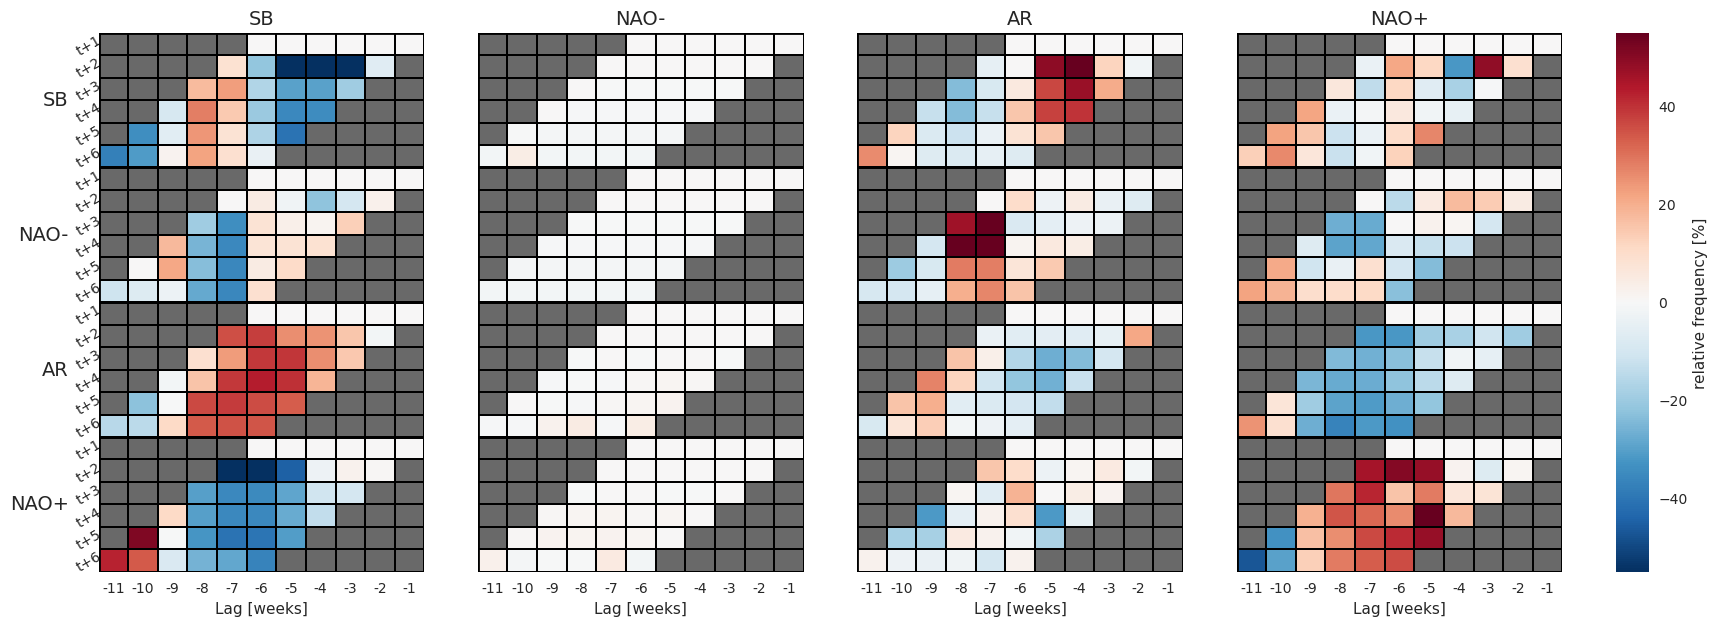

In [34]:
from matplotlib.patches import Rectangle


vmin = np.abs(np.nanmin(probability_nae_array))
vmax = np.nanmax(probability_nae_array)
# vmax = max([vmin,vmax]) 
vmax = 55
delta_t = [-(t+1) for t in range(t_in +t_out-1)]
lead_weeks = [f"t+{k+1}" for k in range(nae_inputs.shape[2])]
ylabs = []
for i in range(len(regimes)):
    for j in range(len(lead_weeks)):
        ylabs.append(lead_weeks[j])

# Initialize the array with random values
fig, axes = plt.subplots(1, len(regimes)+1, figsize=(20, 7), #figsize=(7, 14))
                            gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]})
for i in range(len(regimes)):

    cbar_flag = True if i == len(regimes)-1 else False

    data = probability_nae_array[i, :, :, :]

    # data_flipped = np.flip(data, axis=[1,2])

    subrows = data.shape[1]  # Number of subrows for each row

    data_expanded = data.reshape(-1, data.shape[-1])
    # data_expanded = data_flipped.reshape(-1, data_flipped.shape[-1])


    # Create a DataFrame with subrows
    # in_time = np.array([-5+t for t in range(subrows)])
    # index = np.repeat(in_time[None,:], data.shape[0], axis = 0).flatten()
    out_time = np.array([t+1 for t in range(subrows)])
    index = np.repeat(out_time[None,:], data.shape[0], axis = 0).flatten()
    columns = np.flip(np.array([-(i+1) for i in range(data_expanded.shape[1])]))
    data_flipped = np.flip(data_expanded, axis=1)
    # df = pd.DataFrame(data_expanded, index=index, columns=columns)
    df = pd.DataFrame(data_flipped, index=index, columns=columns)

    # df = df.replace(np. nan,'',regex=True)

    g = sns.heatmap(df, cmap='RdBu_r', square=False, ax = axes[i], vmin=-vmax, vmax = vmax, mask = False, linecolor = 'black', linewidths = 0.05,
                    yticklabels=False, cbar=cbar_flag, cbar_ax=axes[-1], cbar_kws={"label": 'relative frequency [%]'})
    # g = sns.heatmap(df, cmap='viridis', cbar=True, yticklabels=False, mask = False)
    # g.set_yticks(range(data_expanded.shape[0]),index, rotation=0)
    g.set_facecolor("dimgray")
    g.grid(False)
    g.set_xlabel('Lag [weeks]')
    g.set_title(f'{regimes[i]}', fontsize=14)
    # Add subrow labels and squares around subrows
    for j in range(data.shape[0]):
        g.add_patch(Rectangle((0, j * subrows), data_expanded.shape[1], subrows, ec='black', fc='none', lw=2))
    
for j in range(data.shape[0]):
    axes[0].text(-1, j * subrows + subrows / 2, f'{regimes[j]}', va='center', ha='right', fontsize=14)
axes[0].set_yticks(range(data_expanded.shape[0]),ylabs, rotation = 30,va='top', ha='center')

plt.show()

In [101]:
# Save plot data.

np.savez(f'{results_directory}{arch_type}nae_teleconnections.npz', probability_nae_array = probability_nae_array, vmax = vmax, 
         delta_t = delta_t, regimes = regimes, lead_weeks = lead_weeks, ylabs = ylabs)

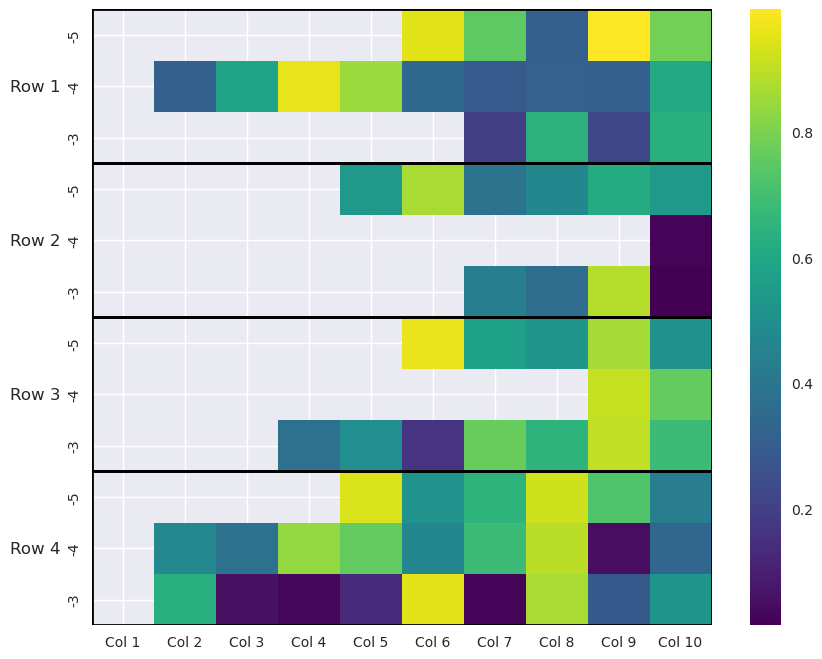

In [102]:
from matplotlib.patches import Rectangle

# Initialize the array with random values
array = np.random.rand(4, 3, 10)

# Introduce shifting NaNs for each row along the dimension of size 10
for i in range(array.shape[0]):
    for j in range(array.shape[1]):
        shift = np.random.randint(0, 10)
        array[i, j, :shift] = np.nan


subrows = 3  # Number of subrows for each row


# Example data
data = array#np.random.rand(4, subrows, 10)
data_expanded = data.reshape(-1, data.shape[-1])

# Create a DataFrame with subrows
in_time = np.array([-5+t for t in range(subrows)])
index = np.repeat(in_time[None,:], data.shape[0], axis = 0).flatten()
# index = np.repeat(np.arange(4), subrows)
columns = [f'Col {i+1}' for i in range(data_expanded.shape[1])]
df = pd.DataFrame(data_expanded, index=index, columns=columns)

# Plot heatmap
plt.figure(figsize=(10, 8))
g = sns.heatmap(df, cmap='viridis', cbar=True, yticklabels=True, mask = False)

# Add subrow labels and squares around subrows
for i in range(data.shape[0]):
    plt.text(-0.5, i * subrows + subrows / 2, f'Row {i+1}', va='center', ha='right', fontsize=12)
    g.add_patch(Rectangle((0, i * subrows), data_expanded.shape[1], subrows, ec='black', fc='none', lw=2))

plt.show()

## 90th percentile per class

In [35]:
lp_conf = loop_probabilities.flatten()
q_all = 90
qall_90 = np.percentile(lp_conf,q_all)
count_mod_class_ts = np.zeros((len(regimes),loop_probabilities.shape[0],loop_probabilities.shape[2]))

all_count =[]
for i in range(loop_probabilities.shape[0]): # num models
    count_mod = 0
    for j in range(loop_probabilities.shape[1]): # num samples
        for k in range(loop_probabilities.shape[2]):
            if loop_probabilities[i,j,k,loop_targets[i,j,k]] > qall_90: 
                count_mod_class_ts[loop_targets[i,j,k], i, k] +=1
                count_mod +=1
    all_count.append(count_mod)

all_count = np.array(all_count)

In [38]:
np.savez(f'{results_directory}{arch_type}nae_teleconnections.npz', probability_nae_array = probability_nae_array, vmax = vmax, 
         delta_t = delta_t, regimes = regimes, lead_weeks = lead_weeks, ylabs = ylabs, all_count = all_count, count_mod_class_ts = count_mod_class_ts, num_samples = loop_probabilities.shape[1])